# Formatting the Data

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load the ratings data and skip any extra headers if present
ratings = pd.read_csv('zee-ratings.dat', sep='::', header=None, names=['UserID', 'MovieID', 'Rating', 'Timestamp'], engine='python')

# Load the movies data with a different encoding
movies = pd.read_csv('zee-movies.dat', sep='::', header=None, names=['MovieID', 'Title', 'Genres'], engine='python', encoding='ISO-8859-1')

# Load the users data and skip any unwanted header rows (if applicable)
users = pd.read_csv('zee-users.dat', sep='::', header=None, names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], engine='python')

# Remove any rows where 'UserID' contains non-numeric values or headers
ratings = ratings[ratings['UserID'] != 'UserID']
users = users[users['UserID'] != 'UserID']

# Convert UserID to integer in both ratings and users dataset
ratings['UserID'] = pd.to_numeric(ratings['UserID'], errors='coerce')
users['UserID'] = pd.to_numeric(users['UserID'], errors='coerce')

# Drop any rows with NaN values in UserID column
ratings = ratings.dropna(subset=['UserID'])
users = users.dropna(subset=['UserID'])

# Convert Timestamp to datetime
ratings['Timestamp'] = pd.to_datetime(ratings['Timestamp'], unit='s')

# Merge the datasets
merged_data = pd.merge(pd.merge(ratings, users, on='UserID'), movies, on='MovieID')

# Display the first few rows of the merged dataset
print(merged_data.head())


   UserID MovieID Rating           Timestamp Gender Age Occupation Zip-code  \
0       1    1193      5 2000-12-31 22:12:40      F   1         10    48067   
1       1     661      3 2000-12-31 22:35:09      F   1         10    48067   
2       1     914      3 2000-12-31 22:32:48      F   1         10    48067   
3       1    3408      4 2000-12-31 22:04:35      F   1         10    48067   
4       1    2355      5 2001-01-06 23:38:11      F   1         10    48067   

                                    Title                        Genres  
0  One Flew Over the Cuckoo's Nest (1975)                         Drama  
1        James and the Giant Peach (1996)  Animation|Children's|Musical  
2                     My Fair Lady (1964)               Musical|Romance  
3                  Erin Brockovich (2000)                         Drama  
4                    Bug's Life, A (1998)   Animation|Children's|Comedy  


# EDA, Data Cleaning, and Feature Engineering

In [19]:
# Check the structure and shape of the dataset
print("Shape of the dataset:", merged_data.shape)
print("\nFirst few rows of the dataset:")
print(merged_data.head())

# Data types of each column
print("\nData types of each column:")
print(merged_data.dtypes)


Shape of the dataset: (1000209, 10)

First few rows of the dataset:
   UserID MovieID Rating           Timestamp Gender Age Occupation Zip-code  \
0       1    1193      5 2000-12-31 22:12:40      F   1         10    48067   
1       1     661      3 2000-12-31 22:35:09      F   1         10    48067   
2       1     914      3 2000-12-31 22:32:48      F   1         10    48067   
3       1    3408      4 2000-12-31 22:04:35      F   1         10    48067   
4       1    2355      5 2001-01-06 23:38:11      F   1         10    48067   

                                    Title                        Genres  
0  One Flew Over the Cuckoo's Nest (1975)                         Drama  
1        James and the Giant Peach (1996)  Animation|Children's|Musical  
2                     My Fair Lady (1964)               Musical|Romance  
3                  Erin Brockovich (2000)                         Drama  
4                    Bug's Life, A (1998)   Animation|Children's|Comedy  

Data types o

In [23]:
# Convert 'Age' column to numeric (forcing errors to NaN)
merged_data['Age'] = pd.to_numeric(merged_data['Age'], errors='coerce')

# Create age group feature based on 'Age' column
bins = [0, 18, 30, 40, 50, 60, 100]  # Define age bins
labels = ['0-18', '19-30', '31-40', '41-50', '51-60', '60+']  # Labels for age groups
merged_data['AgeGroup'] = pd.cut(merged_data['Age'], bins=bins, labels=labels)

# Check the newly added columns
print("\nFirst few rows after feature engineering:")
print(merged_data[['UserID', 'Rating', 'Timestamp', 'Year', 'Month', 'Age', 'AgeGroup']].head())



First few rows after feature engineering:
   UserID  Rating           Timestamp  Year  Month  Age AgeGroup
0       1     5.0 2000-12-31 22:12:40  2000     12    1     0-18
1       1     3.0 2000-12-31 22:35:09  2000     12    1     0-18
2       1     3.0 2000-12-31 22:32:48  2000     12    1     0-18
3       1     4.0 2000-12-31 22:04:35  2000     12    1     0-18
4       1     5.0 2001-01-06 23:38:11  2001      1    1     0-18


In [24]:
# Check for missing values
print("\nMissing values in the dataset:")
print(merged_data.isnull().sum())

# Check for duplicate rows
print("\nNumber of duplicate rows in the dataset:", merged_data.duplicated().sum())

# Check for outliers or unreasonable ratings (e.g., ratings should be between 1 and 5)
print("\nChecking for invalid ratings (ratings < 1 or > 5):")
print(merged_data[merged_data['Rating'] < 1])
print(merged_data[merged_data['Rating'] > 5])

# Drop duplicates if any
merged_data = merged_data.drop_duplicates()

# Handling any potential missing values (if any)
merged_data = merged_data.dropna()  # or use imputation if preferred



Missing values in the dataset:
UserID        0
MovieID       0
Rating        0
Timestamp     0
Gender        0
Age           0
Occupation    0
Zip-code      0
Title         0
Genres        0
Year          0
Month         0
AgeGroup      0
dtype: int64

Number of duplicate rows in the dataset: 0

Checking for invalid ratings (ratings < 1 or > 5):
Empty DataFrame
Columns: [UserID, MovieID, Rating, Timestamp, Gender, Age, Occupation, Zip-code, Title, Genres, Year, Month, AgeGroup]
Index: []
Empty DataFrame
Columns: [UserID, MovieID, Rating, Timestamp, Gender, Age, Occupation, Zip-code, Title, Genres, Year, Month, AgeGroup]
Index: []


In [22]:
# Grouping by MovieID to get average rating and count of ratings per movie
movie_group = merged_data.groupby('MovieID').agg(
    avg_rating=('Rating', 'mean'),
    rating_count=('Rating', 'count')
).reset_index()

# Sorting by rating count (top-rated movies by most ratings)
movie_group_sorted = movie_group.sort_values(by='rating_count', ascending=False)

# Display the first few rows
print("\nMovies grouped by average rating and number of ratings:")
print(movie_group_sorted.head())

# Grouping by UserID to get average rating and count of ratings per user
user_group = merged_data.groupby('UserID').agg(
    avg_rating=('Rating', 'mean'),
    rating_count=('Rating', 'count')
).reset_index()

# Sorting by rating count (most active users)
user_group_sorted = user_group.sort_values(by='rating_count', ascending=False)

# Display the first few rows
print("\nUsers grouped by average rating and number of ratings:")
print(user_group_sorted.head())



Movies grouped by average rating and number of ratings:
     MovieID  avg_rating  rating_count
1916    2858    4.317386          3428
1640     260    4.453694          2991
191     1196    4.292977          2990
208     1210    4.022893          2883
3182     480    3.763847          2672

Users grouped by average rating and number of ratings:
      UserID  avg_rating  rating_count
4168    4169    3.551858          2314
1679    1680    3.555676          1850
4276    4277    4.134825          1743
1940    1941    3.054545          1595
1180    1181    2.815911          1521


#  Recommender System based on Pearson Correlation

In [28]:
# Create the pivot table with UserID as rows and Movie titles as columns
movie_ratings_pivot = merged_data.pivot_table(index='UserID', columns='Title', values='Rating')

# Fill missing values with 0
movie_ratings_pivot_filled = movie_ratings_pivot.fillna(0)

# Verify the filled pivot table
print("Pivot Table after imputing missing values:")
print(movie_ratings_pivot_filled.head())


Pivot Table after imputing missing values:
Title   $1,000,000 Duck (1971)  'Night Mother (1986)  \
UserID                                                 
1                          0.0                   0.0   
2                          0.0                   0.0   
3                          0.0                   0.0   
4                          0.0                   0.0   
5                          0.0                   0.0   

Title   'Til There Was You (1997)  'burbs, The (1989)  \
UserID                                                  
1                             0.0                 0.0   
2                             0.0                 0.0   
3                             0.0                 0.0   
4                             0.0                 0.0   
5                             0.0                 0.0   

Title   ...And Justice for All (1979)  1-900 (1994)  \
UserID                                                
1                                 0.0           0.0   

In [29]:
# Fill missing values with 0 (or other techniques if needed)
movie_ratings_pivot = movie_ratings_pivot.fillna(0)

# Verify the pivot table after imputation
print("\nPivot Table after imputing missing values:")
print(movie_ratings_pivot.head())



Pivot Table after imputing missing values:
Title   $1,000,000 Duck (1971)  'Night Mother (1986)  \
UserID                                                 
1                          0.0                   0.0   
2                          0.0                   0.0   
3                          0.0                   0.0   
4                          0.0                   0.0   
5                          0.0                   0.0   

Title   'Til There Was You (1997)  'burbs, The (1989)  \
UserID                                                  
1                             0.0                 0.0   
2                             0.0                 0.0   
3                             0.0                 0.0   
4                             0.0                 0.0   
5                             0.0                 0.0   

Title   ...And Justice for All (1979)  1-900 (1994)  \
UserID                                                
1                                 0.0           0.0  

In [31]:
# Compute the Pearson correlation matrix
movie_correlation_matrix = movie_ratings_pivot_filled.corr(method='pearson')

# Display a snippet of the correlation matrix
print("\nMovie Correlation Matrix:")
print(movie_correlation_matrix.head())



Movie Correlation Matrix:
Title                          $1,000,000 Duck (1971)  'Night Mother (1986)  \
Title                                                                         
$1,000,000 Duck (1971)                       1.000000              0.065338   
'Night Mother (1986)                         0.065338              1.000000   
'Til There Was You (1997)                    0.030805              0.107374   
'burbs, The (1989)                           0.065478              0.096778   
...And Justice for All (1979)                0.048708              0.144480   

Title                          'Til There Was You (1997)  'burbs, The (1989)  \
Title                                                                          
$1,000,000 Duck (1971)                          0.030805            0.065478   
'Night Mother (1986)                            0.107374            0.096778   
'Til There Was You (1997)                       1.000000            0.082706   
'burbs, The (1989) 

In [32]:
def recommend_movies(movie_title, correlation_matrix, top_n=5):
    # Get correlations for the specified movie
    if movie_title not in correlation_matrix:
        print(f"Movie '{movie_title}' not found in the dataset.")
        return []

    movie_corr = correlation_matrix[movie_title]

    # Sort by correlation score in descending order
    recommendations = movie_corr.sort_values(ascending=False)

    # Exclude the movie itself and get top N recommendations
    recommendations = recommendations.drop(movie_title).head(top_n)
    return recommendations

# Example: Recommend movies similar to "12 Angry Men (1957)"
movie_title = "12 Angry Men (1957)"
recommendations = recommend_movies(movie_title, movie_correlation_matrix)
print(f"\nTop recommendations for '{movie_title}':")
print(recommendations)



Top recommendations for '12 Angry Men (1957)':
Title
To Kill a Mockingbird (1962)            0.316778
Amadeus (1984)                          0.307509
It's a Wonderful Life (1946)            0.300912
Citizen Kane (1941)                     0.294742
Bridge on the River Kwai, The (1957)    0.293340
Name: 12 Angry Men (1957), dtype: float64


# Recommender System based on Cosine Similarity

In [33]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


In [34]:
# Compute User Similarity Matrix
user_similarity_matrix = cosine_similarity(movie_ratings_pivot_filled)

# Convert to DataFrame for better visualization
user_similarity_df = pd.DataFrame(user_similarity_matrix, index=movie_ratings_pivot_filled.index, columns=movie_ratings_pivot_filled.index)

# Display the user similarity matrix
print("User Similarity Matrix:")
print(user_similarity_df.head())


User Similarity Matrix:
UserID      1         2         3         4         5         6         7     \
UserID                                                                         
1       1.000000  0.096382  0.120610  0.132455  0.090158  0.179222  0.059678   
2       0.096382  1.000000  0.151479  0.171176  0.114394  0.100865  0.305787   
3       0.120610  0.151479  1.000000  0.151227  0.062907  0.074603  0.138332   
4       0.132455  0.171176  0.151227  1.000000  0.045094  0.013529  0.130339   
5       0.090158  0.114394  0.062907  0.045094  1.000000  0.047449  0.126257   

UserID      8         9         10    ...      6031      6032      6033  \
UserID                                ...                                 
1       0.138241  0.226148  0.255288  ...  0.170588  0.082006  0.069807   
2       0.203337  0.190198  0.226861  ...  0.112503  0.091222  0.268565   
3       0.077656  0.126457  0.213655  ...  0.092960  0.125864  0.161507   
4       0.100856  0.093651  0.120738  ..

In [35]:
# Compute Item Similarity Matrix
item_similarity_matrix = cosine_similarity(movie_ratings_pivot_filled.T)

# Convert to DataFrame for better visualization
item_similarity_df = pd.DataFrame(item_similarity_matrix, index=movie_ratings_pivot_filled.columns, columns=movie_ratings_pivot_filled.columns)

# Display the item similarity matrix
print("Item Similarity Matrix:")
print(item_similarity_df.head())


Item Similarity Matrix:
Title                          $1,000,000 Duck (1971)  'Night Mother (1986)  \
Title                                                                         
$1,000,000 Duck (1971)                       1.000000              0.072357   
'Night Mother (1986)                         0.072357              1.000000   
'Til There Was You (1997)                    0.037011              0.115290   
'burbs, The (1989)                           0.079291              0.115545   
...And Justice for All (1979)                0.060838              0.159526   

Title                          'Til There Was You (1997)  'burbs, The (1989)  \
Title                                                                          
$1,000,000 Duck (1971)                          0.037011            0.079291   
'Night Mother (1986)                            0.115290            0.115545   
'Til There Was You (1997)                       1.000000            0.098756   
'burbs, The (1989)    

In [36]:
def recommend_items(user_id, pivot_table, item_similarity, top_n=5):
    # Get the user's ratings
    user_ratings = pivot_table.loc[user_id]

    # Compute the weighted average of item similarities based on user's ratings
    scores = item_similarity.dot(user_ratings).div(item_similarity.sum(axis=1))

    # Exclude items already rated by the user
    recommendations = scores[user_ratings == 0].sort_values(ascending=False).head(top_n)

    return recommendations

# Example usage: Recommend items for UserID = 1
user_id = 1
recommendations = recommend_items(user_id, movie_ratings_pivot_filled, item_similarity_df)
print(f"Top Recommendations for User {user_id}:")
print(recommendations)


Top Recommendations for User 1:
Title
Eden (1997)                       0.686704
One Little Indian (1973)          0.320836
Slappy and the Stinkers (1998)    0.308668
Project Moon Base (1953)          0.283266
Alley Cats, The (1968)            0.276903
dtype: float64


# Recommender System based on Matrix Factorization

In [38]:
pip install scikit-surprise


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357282 sha256=7b34a0f4f59b28cd82094d1f20298be41795cacf4e8c1787d7b2afa334fe4df9
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [39]:
import pandas as pd
import numpy as np
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse, mae
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


In [40]:
# Assume the original dataset has columns: ['UserID', 'Title', 'Rating']
# Prepare the data for Surprise library
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(merged_data[['UserID', 'Title', 'Rating']], reader)

# Split the data into training and test sets
trainset, testset = train_test_split(data, test_size=0.2)


In [41]:
# Train the SVD model
model = SVD()
model.fit(trainset)


In [42]:
# Predict on the test set
predictions = model.test(testset)

# RMSE Evaluation
print("Root Mean Squared Error (RMSE):")
rmse(predictions)

# MAPE Evaluation
def mean_absolute_percentage_error(predictions):
    actuals = np.array([pred.r_ui for pred in predictions if pred.r_ui != 0])
    estimates = np.array([pred.est for pred in predictions if pred.r_ui != 0])
    mape = np.mean(np.abs((actuals - estimates) / actuals)) * 100
    return mape

print("Mean Absolute Percentage Error (MAPE):")
print(mean_absolute_percentage_error(predictions))


Root Mean Squared Error (RMSE):
RMSE: 0.8734
Mean Absolute Percentage Error (MAPE):
26.377590957506015


In [44]:
def recommend_movies(user_id, model, movie_titles, top_n=5):
    # Convert movie titles (Index) to a list
    all_movie_ids = movie_titles.tolist()

    # Predict ratings for all movies for the given user
    predictions = [model.predict(user_id, movie_id).est for movie_id in all_movie_ids]

    # Create a DataFrame of movies with predicted ratings
    recommendations = pd.DataFrame({
        'Title': all_movie_ids,  # Use all_movie_ids for the titles
        'Predicted_Rating': predictions
    })

    # Sort by predicted rating and return top N
    recommendations = recommendations.sort_values(by='Predicted_Rating', ascending=False).head(top_n)
    return recommendations

# Example usage
movie_titles = movie_ratings_pivot_filled.columns  # Movie titles extracted from columns
user_id = 1  # Replace with the user ID for whom recommendations are generated
recommendations = recommend_movies(user_id, model, movie_titles)
print(f"Top Recommendations for User {user_id}:")
print(recommendations)


Top Recommendations for User 1:
                             Title  Predicted_Rating
2883                Sanjuro (1962)          4.912796
609              Casablanca (1942)          4.882301
2055    Maltese Falcon, The (1941)          4.851095
1722  It's a Wonderful Life (1946)          4.835877
346                 Ben-Hur (1959)          4.824321


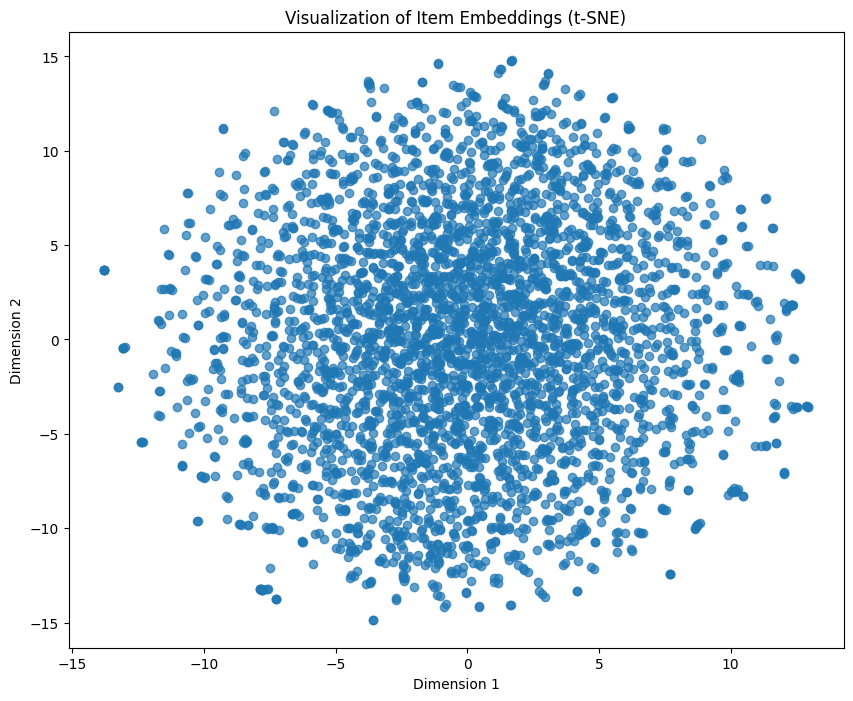

In [45]:
# Extract item embeddings
item_embeddings = model.qi

# Perform t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
item_embeddings_2d = tsne.fit_transform(item_embeddings)

# Plot the embeddings
plt.figure(figsize=(10, 8))
plt.scatter(item_embeddings_2d[:, 0], item_embeddings_2d[:, 1], alpha=0.7)
plt.title("Visualization of Item Embeddings (t-SNE)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


# Recommender System based Pearson Correlation

In [46]:
def compute_pearson_similarity(pivot_table):
    """
    Compute the Pearson Correlation matrix for users.
    """
    return pivot_table.T.corr()

def recommend_movies_pearson(user_id, user_similarity_matrix, pivot_table, top_n=5):
    """
    Recommend movies based on Pearson Correlation.

    Parameters:
    - user_id: ID of the user for whom recommendations are generated.
    - user_similarity_matrix: Matrix containing user-user similarity scores.
    - pivot_table: User-movie ratings pivot table.
    - top_n: Number of recommendations to return.

    Returns:
    - DataFrame of recommended movies with predicted ratings.
    """
    # Get the similarity scores for the given user
    user_similarities = user_similarity_matrix[user_id].drop(user_id)
    user_similarities = user_similarities[user_similarities > 0]  # Consider only positive similarities

    # Get the ratings of other users
    similar_users_ratings = pivot_table.loc[user_similarities.index]

    # Compute weighted average of ratings
    weighted_ratings = np.dot(similar_users_ratings.T, user_similarities) / user_similarities.sum()

    # Convert to a DataFrame
    weighted_ratings_df = pd.DataFrame(weighted_ratings, index=pivot_table.columns, columns=['Predicted_Rating'])

    # Exclude movies already rated by the user
    rated_movies = pivot_table.loc[user_id][pivot_table.loc[user_id] > 0].index
    recommendations = weighted_ratings_df[~weighted_ratings_df.index.isin(rated_movies)]

    # Sort by predicted rating and return top N
    recommendations = recommendations.sort_values(by='Predicted_Rating', ascending=False).head(top_n)
    return recommendations

# Example Usage
# Compute the Pearson Correlation matrix
user_similarity_matrix = compute_pearson_similarity(movie_ratings_pivot_filled)

# Recommend movies for a specific user
user_id = 1
recommendations = recommend_movies_pearson(user_id, user_similarity_matrix, movie_ratings_pivot_filled)

print(f"Top Recommendations for User {user_id}:")
print(recommendations)


Top Recommendations for User 1:
                                                    Predicted_Rating
Title                                                               
American Beauty (1999)                                      2.640426
Star Wars: Episode V - The Empire Strikes Back ...          2.554190
Raiders of the Lost Ark (1981)                              2.279832
Silence of the Lambs, The (1991)                            2.232998
Star Wars: Episode VI - Return of the Jedi (1983)           2.221564
